# Contrast Model & Fairness Model
This notebook will explore the possibilities of creating predictive models for traffic stop outcome while including race in a fair way. To do this, it will explore two main approaches: obfuscating race and gender through a "contrast" datasource, and using scikit-learn fairness metrics to penalize race in model performance and selection.

## Import Packages

In [ ]:
!pip install scikit-lego
# uncomment to install scikit-lego (sklego)

     |████████████████████████████████| 223 kB 5.1 MB/s 
     |████████████████████████████████| 88 kB 6.5 MB/s 
     |████████████████████████████████| 1.1 MB 71.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=b499919c2d82c3dd2cfa4c8bfdd879bf0eb2681bf77d7b9de1f9361f9911df27
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=f18b221e73e2b74c46cf1f6b852ae6b8c8fadf5b15c1dcfe2c417e7e68876d23
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [ ]:
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTENC

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklego.linear_model import DemographicParityClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import matthews_corrcoef, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

In [ ]:
def load_data(who):
  if who == 'MJ':
    train = pd.read_csv('/content/drive/MyDrive/DSBA 6156 Colab/Datasources/Processed/stops_2020_train.csv')
    test = pd.read_csv('/content/drive/MyDrive/DSBA 6156 Colab/Datasources/Processed/stops_2020_test.csv')
  else:
    train = pd.read_csv('stops_2020_train.csv')
    test = pd.read_csv('stops_2020_test.csv')
  return train, test

In [ ]:
train, test = load_data('sv')

In [ ]:
train['Was_a_Search_Conducted'].value_counts()

0    95794
1     5798
Name: Was_a_Search_Conducted, dtype: int64

## Upsampling

In [ ]:
def upsample_process(data, desired_col):
  # Drops uninteresting columns
  # Upsamples appropriately and returns training data, upsampled.
  data_colsdropped = data.drop(['Unnamed: 0', 'Month_of_Stop', 'Result_of_Stop', 'Outcome'], axis = 1)
  X = data_colsdropped[(data_colsdropped.columns[data_colsdropped.columns != 'Was_a_Search_Conducted']) \
                       & (data_colsdropped.columns[data_colsdropped.columns != 'Arrest'])]
  Y = data_colsdropped[['Was_a_Search_Conducted', 'Arrest']]
  cat_cols = X.columns.isin(['Reason_for_Stop', 'Officer_Race',\
                             'Officer_Gender', 'Driver_Race',\
                             'Driver_Ethnicity','Driver_Gender',\
                             'CMPD_Division', 'Racial_Match'])
  su = SMOTENC(categorical_features=cat_cols, random_state=42)
  try:
    X_upsample, Y_upsample = su.fit_resample(X, Y[desired_col])
  except KeyError:
    print('Could not find that column in data!')
    return _,_
  print('X resample shape: {}'.format(X_upsample.shape))
  print('Y resample shape: {}'.format(Y_upsample.shape))
  return pd.concat([X_upsample, Y_upsample], axis = 1)

In [ ]:
train_upsample = upsample_process(train, 'Was_a_Search_Conducted')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  """


X resample shape: (191588, 10)
Y resample shape: (191588,)


In [ ]:
train_upsample.head()

,Reason_for_Stop,Officer_Race,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Ethnicity,Driver_Gender,Driver_Age,CMPD_Division,Racial_Match,Was_a_Search_Conducted
0,Speeding,White,1,27,Black,1,0,54,North Division,0,0
1,Speeding,Black,1,5,White,0,1,20,North Division,0,0
2,Stop Light/Sign,White,1,20,White,1,1,44,Independence Division,1,0
3,Vehicle Regulatory,White,1,1,Black,1,1,35,Metro Division,0,1
4,Speeding,White,1,31,White,1,1,19,Providence Division,1,0


In [ ]:
# if you'd like to run models with not-upsampled data, try uncommenting this line of code.
# the result of the pipeline will still be called "X_train"
# train_upsample = train.copy()

## Creating Contrast Datasource

In [ ]:
def OH_Encode(df, columns):
  OH = OneHotEncoder()

  new = pd.DataFrame(OH.fit_transform(df[columns]).toarray())
  cols = []
  for index, val in enumerate(columns):
    cols += [val + '_' + x.strip() for x in list(OH.categories_[index])]

  new.columns = cols

  return pd.concat([df, new], axis = 1).drop(columns, axis = 1)

In [ ]:
def prepare_contrast(data, desired_col):
  contrast_start = data.copy()
  contrast_mid = OH_Encode(contrast_start, ['Reason_for_Stop', 'CMPD_Division'])

  try:
    contrast_mid = contrast_mid.drop(['Unnamed: 0', 'Month_of_Stop', 'Result_of_Stop', 'Outcome', 'Arrest'], axis = 1)
  except:
    pass
  
  contrast_mid['Gender_Match'] = (contrast_mid['Officer_Gender'] == contrast_mid['Driver_Gender']).astype('int')
  contrast_final = contrast_mid.drop(['Officer_Race', 'Driver_Race',  'Officer_Gender', 'Driver_Gender'], axis = 1)
  contrast_X = contrast_final[(contrast_final.columns[contrast_final.columns != 'Was_a_Search_Conducted']) & (contrast_final.columns[contrast_final.columns != 'Arrest'])]
  contrast_T = contrast_final[desired_col]
  return contrast_X, contrast_T

In [ ]:
X_train_contrast, T_train_contrast = prepare_contrast(train_upsample, 'Was_a_Search_Conducted')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if sys.path[0] == '':


In [ ]:
X_test_contrast, T_test_contrast = prepare_contrast(test, 'Was_a_Search_Conducted')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if sys.path[0] == '':


In [ ]:
X_test_contrast.head()

,Officer_Years_of_Service,Driver_Ethnicity,Driver_Age,Racial_Match,Reason_for_Stop_CheckPoint,Reason_for_Stop_Driving While Impaired,Reason_for_Stop_Investigation,Reason_for_Stop_Other,Reason_for_Stop_Safe Movement,Reason_for_Stop_SeatBelt,...,CMPD_Division_Independence Division,CMPD_Division_Metro Division,CMPD_Division_North Division,CMPD_Division_North Tryon Division,CMPD_Division_Providence Division,CMPD_Division_South Division,CMPD_Division_Steele Creek Division,CMPD_Division_University City Division,CMPD_Division_Westover Division,Gender_Match
0,11,0,25,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,14,0,52,1,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,4,1,30,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,2,1,38,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,21,0,30,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Creating Datasource for Main Classifiers


In [ ]:
def return_race(s):
  race_dict = {'Black':1, 'White':0, 'Other/Unknown':1, 'Asian':1, 'Native American':1}
  return race_dict[s]

In [ ]:
def prepare_normal(data, desired_col):
  normal_data = OH_Encode(data, ['Reason_for_Stop', 'CMPD_Division', 'Officer_Race'])

  # Tries to drop columns if it can.
  try:
    normal_data = normal_data.drop(['Racial_Match'], axis = 1)
    normal_data = normal_data.drop(['Unnamed: 0', 'Month_of_Stop', 'Result_of_Stop', 'Outcome'], axis = 1)
  except:
    pass

  # Transform Values for Arrest, Race, and Searches.
  #normal_data['Arrest'] = [1 if x == 'Arrest' else 0 for x in normal_data['Arrest']]
  normal_data['Driver_Race'] = normal_data['Driver_Race'].map(return_race)
  # normal_data['Was_a_Search_Conducted'] = [1 if x == 0 else 0 for x in normal_data['Was_a_Search_Conducted']]

  # Subset to desired columns.
  final_X = normal_data[(normal_data.columns[normal_data.columns != 'Was_a_Search_Conducted']) & (normal_data.columns[normal_data.columns != 'Arrest'])]
  final_T = normal_data[desired_col]
  return final_X, final_T

In [ ]:
X_train, T_train = prepare_normal(train_upsample, 'Was_a_Search_Conducted')
X_test, T_test = prepare_normal(test, 'Was_a_Search_Conducted')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


## Train and Eval Functions

In [ ]:
def train_eval(clf, X_train, t_train, X_test, t_test, info):
    clf.fit(X_train, t_train)

    train_score = clf.score(X_train, t_train)
    test_score = clf.score(X_test, t_test)

    print("{}> Train Accuracy: {}, Test Accuracy: {}".format(info['clf'], train_score, test_score))
    test_pred = clf.predict(X_test)
    
    print("{}> MCC is {}".format(info['clf'], matthews_corrcoef(t_test, test_pred)))
    print(classification_report(t_test, test_pred))
    
    cm = confusion_matrix(t_test, test_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(info['clf'])
    plt.show()
    
    # Residual Plot
    #residuals = t_test - test_pred
    #plt.scatter(X_test[col], residuals)
    #plt.title('Residuals for {} for {}'.format(name, col))
    #plt.show()

In [ ]:
models = [LogisticRegression(max_iter = 500), GradientBoostingClassifier(), KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(), DemographicParityClassifier(sensitive_cols="Driver_Race", covariance_threshold=0.80)]
names = ["Logistic Reg", "GradientBoostingClassifier", 'KNeighborsClassifier', 'GaussianNB', 'RandomForest', 'DemographicParityClassifier']

## Baseline Classifier Performance - Upsampled Data

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Reg> Train Accuracy: 0.7678038290498361, Test Accuracy: 0.7296834396409166
Logistic Reg> MCC is 0.26031903824824154
              precision    recall  f1-score   support

           0       0.98      0.73      0.84     31936
           1       0.15      0.79      0.25      1928

    accuracy                           0.73     33864
   macro avg       0.57      0.76      0.54     33864
weighted avg       0.94      0.73      0.80     33864



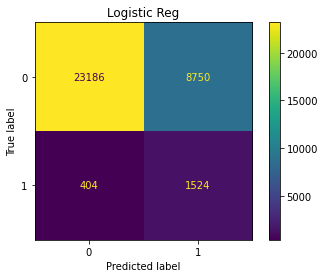

GradientBoostingClassifier> Train Accuracy: 0.8711453744493393, Test Accuracy: 0.8232045830380345
GradientBoostingClassifier> MCC is 0.27532020240812244
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     31936
           1       0.19      0.63      0.29      1928

    accuracy                           0.82     33864
   macro avg       0.58      0.73      0.59     33864
weighted avg       0.93      0.82      0.86     33864



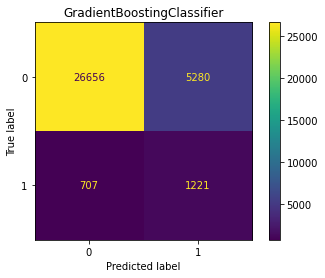

KNeighborsClassifier> Train Accuracy: 0.9244733490615279, Test Accuracy: 0.8033900307110796
KNeighborsClassifier> MCC is 0.1969927690338672
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     31936
           1       0.15      0.52      0.23      1928

    accuracy                           0.80     33864
   macro avg       0.56      0.67      0.56     33864
weighted avg       0.92      0.80      0.85     33864



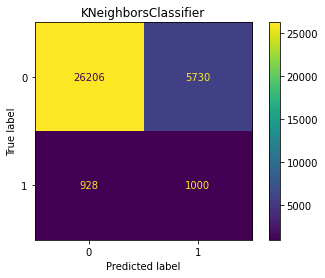

GaussianNB> Train Accuracy: 0.7502714157462889, Test Accuracy: 0.7157453342782897
GaussianNB> MCC is 0.22363316518227838
              precision    recall  f1-score   support

           0       0.98      0.71      0.83     31936
           1       0.13      0.73      0.23      1928

    accuracy                           0.72     33864
   macro avg       0.56      0.72      0.53     33864
weighted avg       0.93      0.72      0.79     33864



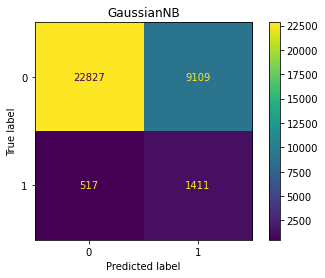

RandomForest> Train Accuracy: 0.9748418481324509, Test Accuracy: 0.9036439877155682
RandomForest> MCC is 0.21080596931836892
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     31936
           1       0.23      0.30      0.26      1928

    accuracy                           0.90     33864
   macro avg       0.59      0.62      0.60     33864
weighted avg       0.92      0.90      0.91     33864



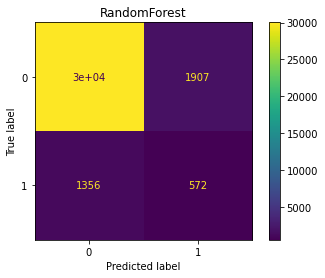

DemographicParityClassifier> Train Accuracy: 0.768075244796125, Test Accuracy: 0.7297129695251595
DemographicParityClassifier> MCC is 0.260110617279198
              precision    recall  f1-score   support

           0       0.98      0.73      0.84     31936
           1       0.15      0.79      0.25      1928

    accuracy                           0.73     33864
   macro avg       0.57      0.76      0.54     33864
weighted avg       0.94      0.73      0.80     33864



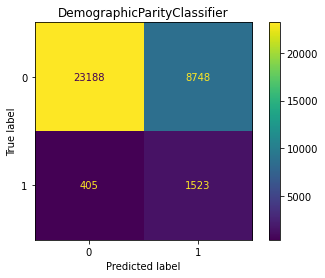

In [ ]:
for name, model in zip(names, models):
    info = {'clf':name, 'data':'Charlotte Policing'}
    train_eval(model, X_train, T_train, X_test, T_test, info)

## Baseline Classifier Performance - Contrast


In [ ]:
models = [LogisticRegression(max_iter = 1000), GradientBoostingClassifier(), GaussianNB()]
names = ["Logistic Reg", "GradientBoostingClassifier", 'GaussianNB']

Logistic Reg> Train Accuracy: 0.786510637409441, Test Accuracy: 0.7440644932671864
Logistic Reg> MCC is 0.2650447448711235
              precision    recall  f1-score   support

           0       0.98      0.74      0.85     31936
           1       0.15      0.78      0.26      1928

    accuracy                           0.74     33864
   macro avg       0.57      0.76      0.55     33864
weighted avg       0.93      0.74      0.81     33864



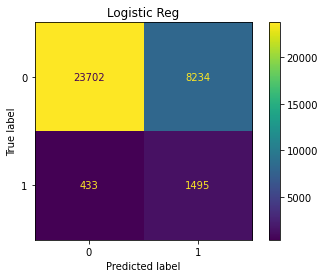

GradientBoostingClassifier> Train Accuracy: 0.8047215900787106, Test Accuracy: 0.7446846208362863
GradientBoostingClassifier> MCC is 0.27812124330293286
              precision    recall  f1-score   support

           0       0.98      0.74      0.85     31936
           1       0.16      0.80      0.26      1928

    accuracy                           0.74     33864
   macro avg       0.57      0.77      0.55     33864
weighted avg       0.94      0.74      0.81     33864



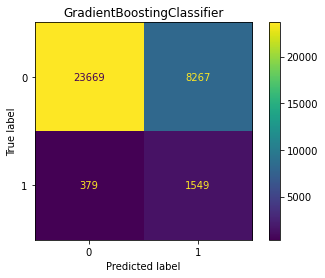

GaussianNB> Train Accuracy: 0.758215545858822, Test Accuracy: 0.6714800377982518
GaussianNB> MCC is 0.2261300140538005
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     31936
           1       0.13      0.81      0.22      1928

    accuracy                           0.67     33864
   macro avg       0.55      0.73      0.51     33864
weighted avg       0.93      0.67      0.76     33864



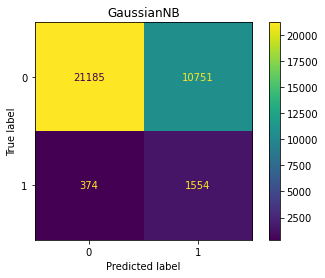

In [ ]:
for name, model in zip(names, models):
    info = {'clf':name, 'data':'Charlotte Policing'}
    train_eval(model, X_train, T_train, X_test, T_test, info)

## Fine Tuning Best Normal Classifiers (Include and Exclude Race)

#### Drop "Driver_Race" variable to see how it affects metrics.

In [ ]:
# Creating dataframes (from upsampled DFs) with Driver_Race dropped
X_train_res_race_dropped = X_train.drop(["Driver_Race"], axis = 1)
X_test_normal_race_dropped = X_test.drop(["Driver_Race"], axis = 1)

In [ ]:
# Modeling DFs with Driver_Race dropped.
for name, model in zip(names, models):
    info = {'clf':name, 'data':'Charlotte Policing'}
    # NOTE: DemographicParityClassifier doesn't work with the new X train/test DFs due to shape issues
    train_eval(model, X_train_res_race_dropped, T_train, X_test_normal_race_dropped, T_test, info)

### The performance was negligibly different across the board with regards to Prec. and Recall for each 
#   classifier, with marginal drops in Train and Test accuracy for a majority of classifiers. Thus, 
#   Driver_Race has some marginal positive effect on Train/Test accuracy for most of the classifiers
#   so it should be kept, especially if the runtime is largely the same with or w/o it.

KeyboardInterrupt: ignored

#### Drop low-covariance columns to see how they affect metrics.

In [ ]:
# see what columns are in X_train
X_train.head()

,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Ethnicity,Driver_Gender,Driver_Age,Reason_for_Stop_CheckPoint,Reason_for_Stop_Driving While Impaired,Reason_for_Stop_Investigation,Reason_for_Stop_Other,...,CMPD_Division_Providence Division,CMPD_Division_South Division,CMPD_Division_Steele Creek Division,CMPD_Division_University City Division,CMPD_Division_Westover Division,Officer_Race_Asian,Officer_Race_Black,Officer_Race_Native American,Officer_Race_Other/Unknown,Officer_Race_White
0,1,27,1,1,0,54,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,5,0,0,1,20,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,20,0,1,1,44,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,1,1,1,1,35,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,31,0,1,1,19,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
import seaborn as sns

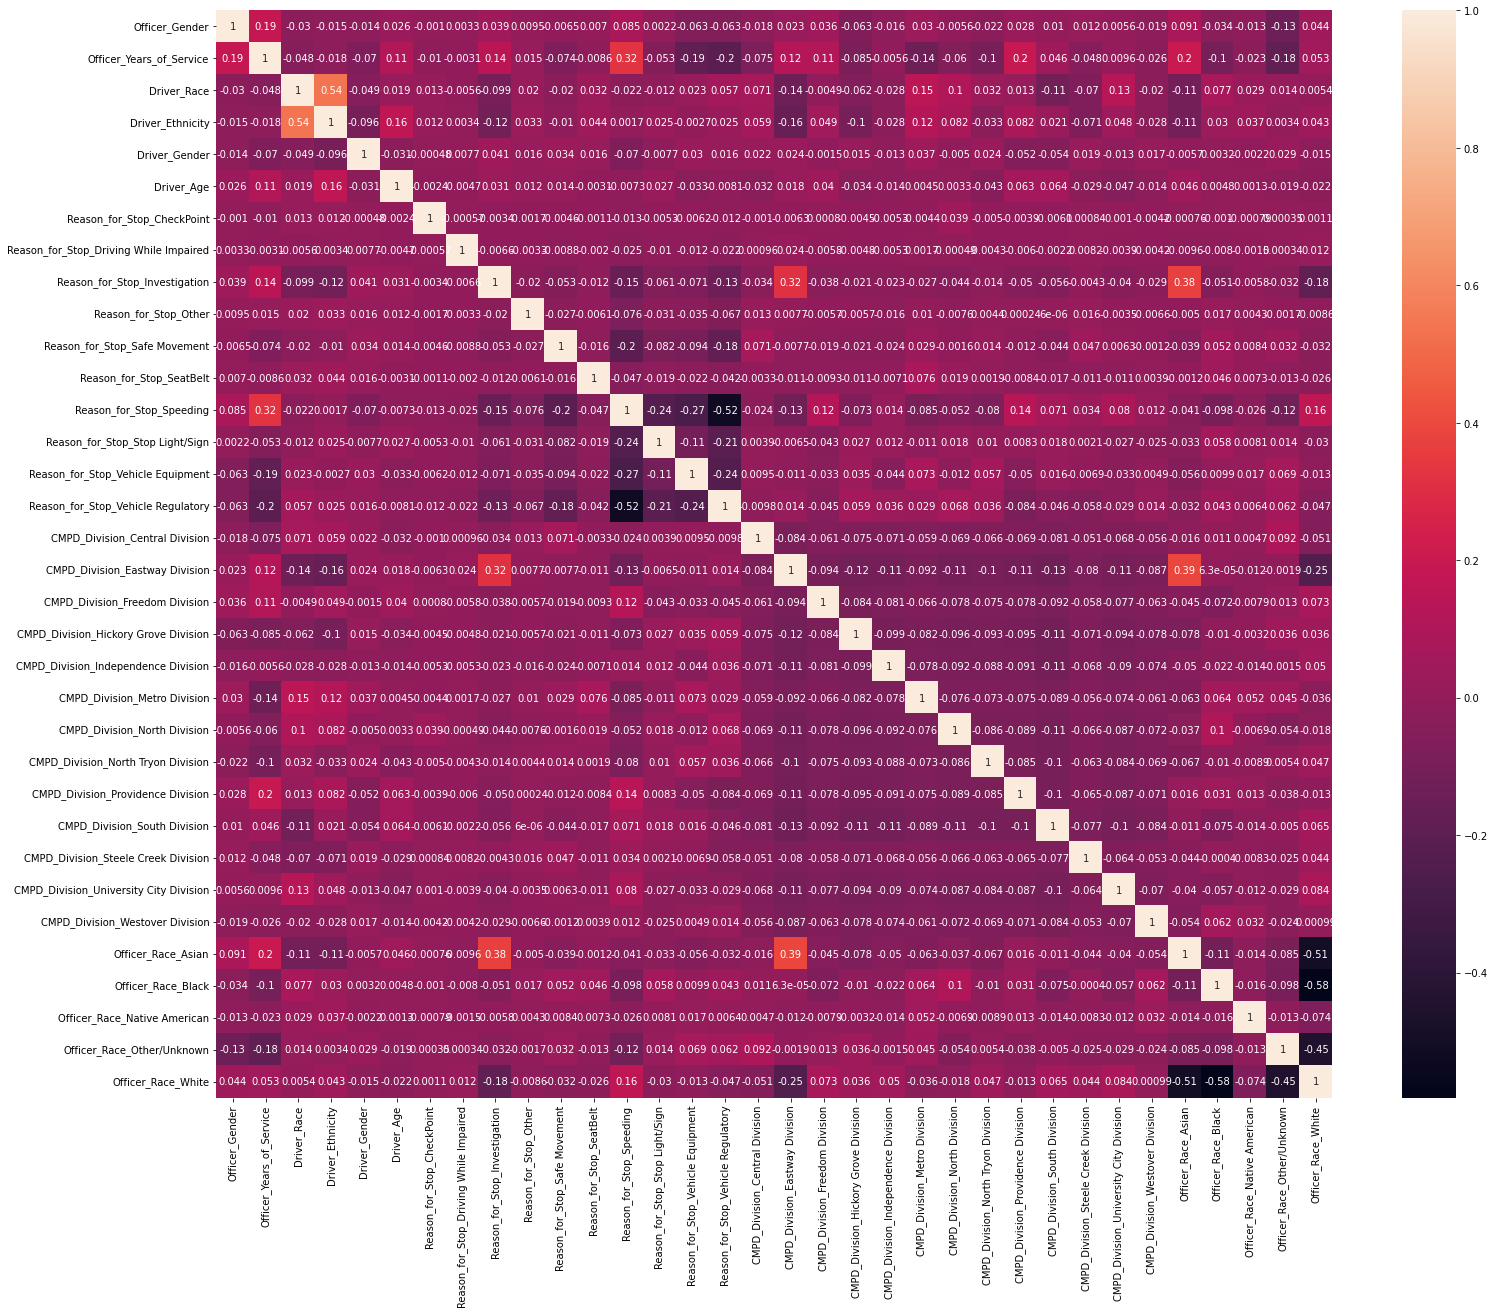

In [ ]:
# checking correlation between variables, esp. between race and other variables
plt.figure(figsize=(25,20))
sns.heatmap(X_train.corr(), annot=True)

In [ ]:
# drop a few neg. correlated vars from train/test

X_train_reduced = X_train.drop(["Officer_Gender","Officer_Years_of_Service","Driver_Age"], axis = 1)
X_test_reduced = X_test.drop(["Officer_Gender","Officer_Years_of_Service","Driver_Age"], axis = 1)

Logistic Reg> Train Accuracy: 0.7458765684698415, Test Accuracy: 0.7097507677769903
Logistic Reg> MCC is 0.23502791081548477
              precision    recall  f1-score   support

           0       0.98      0.71      0.82     31936
           1       0.14      0.77      0.23      1928

    accuracy                           0.71     33864
   macro avg       0.56      0.74      0.53     33864
weighted avg       0.93      0.71      0.79     33864



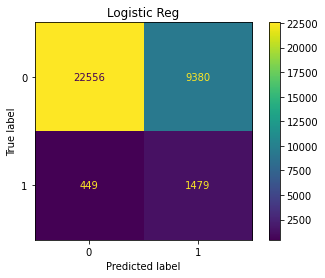

GradientBoostingClassifier> Train Accuracy: 0.8546777459966177, Test Accuracy: 0.821491849751949
GradientBoostingClassifier> MCC is 0.22754208082958471
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     31936
           1       0.17      0.54      0.26      1928

    accuracy                           0.82     33864
   macro avg       0.57      0.69      0.58     33864
weighted avg       0.92      0.82      0.86     33864



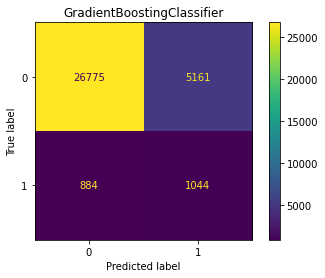

KNeighborsClassifier> Train Accuracy: 0.8489884543917156, Test Accuracy: 0.8366702102527758
KNeighborsClassifier> MCC is 0.21445334449390055
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     31936
           1       0.17      0.48      0.25      1928

    accuracy                           0.84     33864
   macro avg       0.57      0.67      0.58     33864
weighted avg       0.92      0.84      0.87     33864



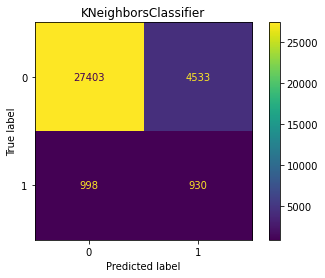

GaussianNB> Train Accuracy: 0.7323840741591331, Test Accuracy: 0.7045239782660052
GaussianNB> MCC is 0.20958853821321385
              precision    recall  f1-score   support

           0       0.98      0.70      0.82     31936
           1       0.13      0.72      0.22      1928

    accuracy                           0.70     33864
   macro avg       0.55      0.71      0.52     33864
weighted avg       0.93      0.70      0.78     33864



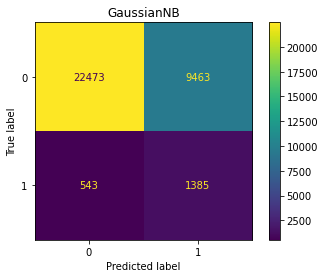

RandomForest> Train Accuracy: 0.8721214272292628, Test Accuracy: 0.8473009685802032
RandomForest> MCC is 0.21403386198975982
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     31936
           1       0.18      0.46      0.25      1928

    accuracy                           0.85     33864
   macro avg       0.57      0.66      0.58     33864
weighted avg       0.92      0.85      0.88     33864



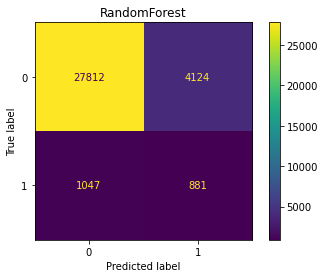

DemographicParityClassifier> Train Accuracy: 0.741132012443368, Test Accuracy: 0.6953401842664777
DemographicParityClassifier> MCC is 0.2230594001165301
              precision    recall  f1-score   support

           0       0.98      0.69      0.81     31936
           1       0.13      0.76      0.22      1928

    accuracy                           0.70     33864
   macro avg       0.55      0.73      0.52     33864
weighted avg       0.93      0.70      0.78     33864



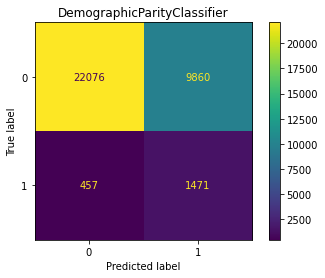

In [ ]:
# check metrics to see how dropping the vars affected metrics
for name, model in zip(names, models):
    info = {'clf':name, 'data':'Charlotte Policing'}
    train_eval(model, X_train_reduced, T_train, X_test_reduced, T_test, info)

### After running this with the reduced dataset, it was observed that the metrics either marginally improved for recall,
#   or were worse consistently across models. Next step could be statistical (K Best) and/or wrapper methods (Seq. Feature Selector) 

#### Stats-based feature selection (Filter Methods)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
import matplotlib.pyplot as plt

In [ ]:
# run this block if you'd like to try with Officer_POC to see its importance instead of the one-hot encoded race.
#X_train['Officer_POC'] = [0 if x == 'White' else 1 for x in X_train['Officer_Race_White']]
#X_train.drop(['Officer_Race_Asian', 'Officer_Race_Black', 'Officer_Race_Native American', 'Officer_Race_Other/Unknown', 'Officer_Race_White'], inplace = True, axis = 1)
#X_test['Officer_POC'] = [0 if x == 'White' else 1 for x in X_test['Officer_Race_White']]
#X_test.drop(['Officer_Race_Asian', 'Officer_Race_Black', 'Officer_Race_Native American', 'Officer_Race_Other/Unknown', 'Officer_Race_White'], inplace = True, axis = 1)

In [ ]:
X_train.shape

(191588, 34)

In [ ]:
X_train.columns

Index(['Officer_Gender', 'Officer_Years_of_Service', 'Driver_Race',
       'Driver_Ethnicity', 'Driver_Gender', 'Driver_Age',
       'Reason_for_Stop_CheckPoint', 'Reason_for_Stop_Driving While Impaired',
       'Reason_for_Stop_Investigation', 'Reason_for_Stop_Other',
       'Reason_for_Stop_Safe Movement', 'Reason_for_Stop_SeatBelt',
       'Reason_for_Stop_Speeding', 'Reason_for_Stop_Stop Light/Sign',
       'Reason_for_Stop_Vehicle Equipment',
       'Reason_for_Stop_Vehicle Regulatory', 'CMPD_Division_Central Division',
       'CMPD_Division_Eastway Division', 'CMPD_Division_Freedom Division',
       'CMPD_Division_Hickory Grove Division',
       'CMPD_Division_Independence Division', 'CMPD_Division_Metro Division',
       'CMPD_Division_North Division', 'CMPD_Division_North Tryon Division',
       'CMPD_Division_Providence Division', 'CMPD_Division_South Division',
       'CMPD_Division_Steele Creek Division',
       'CMPD_Division_University City Division',
       'CMPD_Division

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Feature 0, Officer_Gender: 2.395181
Feature 1, Officer_Years_of_Service: 7346.900486
Feature 2, Driver_Race: 2619.402859
Feature 3, Driver_Ethnicity: 121.356888
Feature 4, Driver_Gender: 4309.040942
Feature 5, Driver_Age: 735.499472
Feature 6, Reason_for_Stop_CheckPoint: 38.207547
Feature 7, Reason_for_Stop_Driving While Impaired: 720.000000
Feature 8, Reason_for_Stop_Investigation: 2761.796882
Feature 9, Reason_for_Stop_Other: 0.334757
Feature 10, Reason_for_Stop_Safe Movement: 217.438948
Feature 11, Reason_for_Stop_SeatBelt: 288.704169
Feature 12, Reason_for_Stop_Speeding: 19264.235078
Feature 13, Reason_for_Stop_Stop Light/Sign: 585.746758
Feature 14, Reason_for_Stop_Vehicle Equipment: 2761.693009
Feature 15, Reason_for_Stop_Vehicle Regulatory: 3048.079428
Feature 16, CMPD_Division_Central Division: 87.745164
Feature 17, CMPD_Division_Eastway Division: 595.060194
Feature 18, CMPD_Division_Freedom Division: 794.593250
Feature 19, CMPD_Division_Hickory Grove Division: 15.065641
Featur

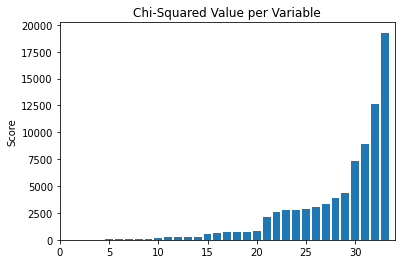

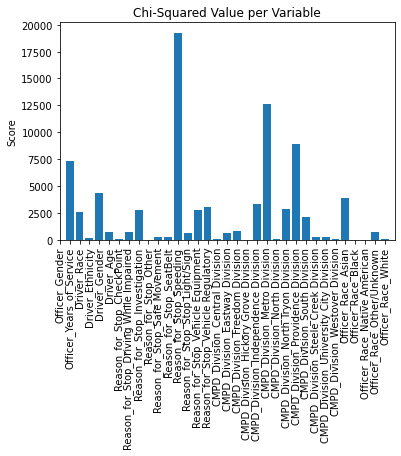

In [ ]:
# feature selection: chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler
x_1 = MinMaxScaler().fit_transform(X_train)

def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs


X_train_fs, X_test_fs, fs = select_features(x_1, T_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d, ' % (i) + X_train.columns[i] + ': %f' % (fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], np.sort(fs.scores_))
#plt.xticks(rotation = 90)
plt.xlim(0,34)
plt.ylabel("Score")
plt.title("Chi-Squared Value per Variable")
plt.show()


plt.bar([X_train.columns[i] for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(rotation = 90)
plt.xlim(0,34)
plt.ylabel("Score")
plt.title("Chi-Squared Value per Variable")
plt.show()

### NOTE, THE FEATURE NUMBERS DO NOT MATCH BETWEEN THE SORTED GRAPH AND THE TEXT OUTPUT

In [ ]:
np.sort(fs.scores_)

array([3.34756618e-01, 2.39518116e+00, 4.28941570e+00, 9.91011236e+00,
       1.50656406e+01, 3.34965014e+01, 3.41252161e+01, 3.82075472e+01,
       8.77451640e+01, 1.07345651e+02, 1.21356888e+02, 2.17438948e+02,
       2.18680250e+02, 2.76220611e+02, 2.88704169e+02, 5.85746758e+02,
       5.95060194e+02, 7.15642294e+02, 7.20000000e+02, 7.35499472e+02,
       7.94593250e+02, 2.12425396e+03, 2.61940286e+03, 2.76169301e+03,
       2.76179688e+03, 2.87409184e+03, 3.04807943e+03, 3.30842821e+03,
       3.91495707e+03, 4.30904094e+03, 7.34690049e+03, 8.94329173e+03,
       1.26307842e+04, 1.92642351e+04])

In [ ]:
# Obtain the indexes of the 7 columns that contain the lowest chi^2 values
lowest_7_indexes = [list(fs.scores_).index(val) for val in sorted(list(fs.scores_))[:7]]

# New DFs that will contain the undropped features (based on the chi^2 vals above)
X_train_res_c2_drop = X_train.copy()
X_test_norm_c2_drop = X_test.copy()

# Iteratively drop the variables that corresond the lowest 7 chi^2 vals
for index in lowest_7_indexes:
  X_train_res_c2_drop.drop(X_train.columns[index], axis=1, inplace=True)
  X_test_norm_c2_drop.drop(X_test.columns[index], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Reg> Train Accuracy: 0.7835094055995157, Test Accuracy: 0.7420859910229152
Logistic Reg> MCC is 0.2631989505742518
              precision    recall  f1-score   support

           0       0.98      0.74      0.84     31936
           1       0.15      0.77      0.25      1928

    accuracy                           0.74     33864
   macro avg       0.57      0.76      0.55     33864
weighted avg       0.93      0.74      0.81     33864



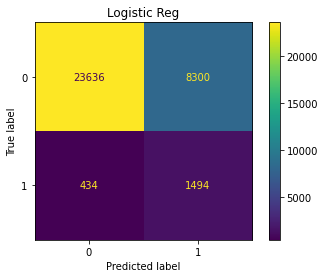

GradientBoostingClassifier> Train Accuracy: 0.7979309768879053, Test Accuracy: 0.7396054807465154
GradientBoostingClassifier> MCC is 0.27281209496961084
              precision    recall  f1-score   support

           0       0.98      0.74      0.84     31936
           1       0.15      0.80      0.26      1928

    accuracy                           0.74     33864
   macro avg       0.57      0.77      0.55     33864
weighted avg       0.94      0.74      0.81     33864



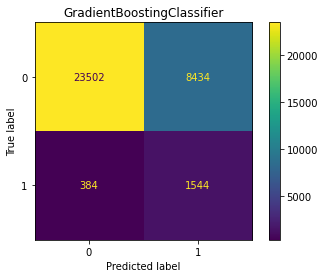

KNeighborsClassifier> Train Accuracy: 0.8875033926968287, Test Accuracy: 0.7662709662178124
KNeighborsClassifier> MCC is 0.2140397368479373
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     31936
           1       0.14      0.62      0.23      1928

    accuracy                           0.77     33864
   macro avg       0.56      0.70      0.55     33864
weighted avg       0.92      0.77      0.83     33864



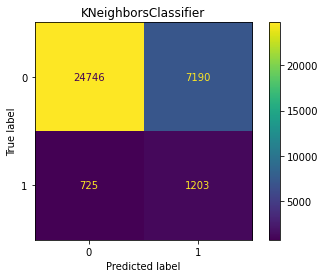

GaussianNB> Train Accuracy: 0.758225984925987, Test Accuracy: 0.670623671155209
GaussianNB> MCC is 0.22557882237425023
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     31936
           1       0.13      0.81      0.22      1928

    accuracy                           0.67     33864
   macro avg       0.55      0.73      0.50     33864
weighted avg       0.93      0.67      0.76     33864



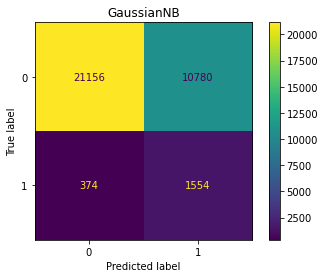

RandomForest> Train Accuracy: 0.9333152389502474, Test Accuracy: 0.836433971178833
RandomForest> MCC is 0.22375901871342102
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     31936
           1       0.17      0.50      0.26      1928

    accuracy                           0.84     33864
   macro avg       0.57      0.68      0.58     33864
weighted avg       0.92      0.84      0.87     33864



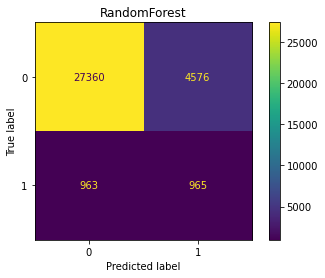

DemographicParityClassifier> Train Accuracy: 0.7845219951145166, Test Accuracy: 0.7414658634538153
DemographicParityClassifier> MCC is 0.265491397475624
              precision    recall  f1-score   support

           0       0.98      0.74      0.84     31936
           1       0.15      0.78      0.26      1928

    accuracy                           0.74     33864
   macro avg       0.57      0.76      0.55     33864
weighted avg       0.94      0.74      0.81     33864



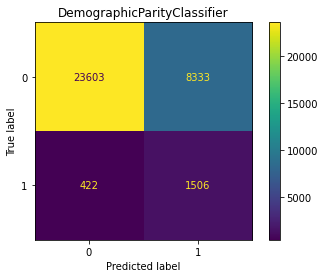

In [ ]:
# check metrics to see how dropping the lowest 7 relevant variables affected metrics
for name, model in zip(names, models):
    info = {'clf':name, 'data':'Charlotte Policing'}
    train_eval(model, X_train_res_c2_drop, T_train, X_test_norm_c2_drop, T_test, info)


Feature 0, Officer_Gender: 0.019225
Feature 1, Officer_Years_of_Service: 0.105322
Feature 2, Driver_Race: 0.035920
Feature 3, Driver_Ethnicity: 0.022593
Feature 4, Driver_Gender: 0.058122
Feature 5, Driver_Age: 0.025454
Feature 6, Reason_for_Stop_CheckPoint: 0.001647
Feature 7, Reason_for_Stop_Driving While Impaired: 0.001502
Feature 8, Reason_for_Stop_Investigation: 0.006990
Feature 9, Reason_for_Stop_Other: 0.000098
Feature 10, Reason_for_Stop_Safe Movement: 0.000122
Feature 11, Reason_for_Stop_SeatBelt: 0.000056
Feature 12, Reason_for_Stop_Speeding: 0.070502
Feature 13, Reason_for_Stop_Stop Light/Sign: 0.002470
Feature 14, Reason_for_Stop_Vehicle Equipment: 0.009219
Feature 15, Reason_for_Stop_Vehicle Regulatory: 0.017586
Feature 16, CMPD_Division_Central Division: 0.000142
Feature 17, CMPD_Division_Eastway Division: 0.001915
Feature 18, CMPD_Division_Freedom Division: 0.002832
Feature 19, CMPD_Division_Hickory Grove Division: 0.000274
Feature 20, CMPD_Division_Independence Division

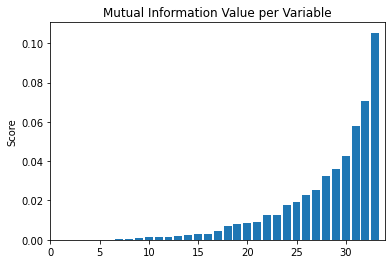

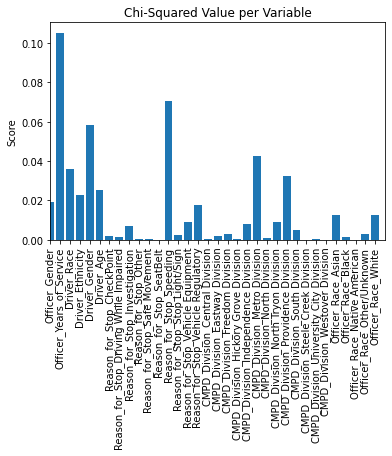

In [ ]:
# feature selection: mutual_info_classif
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=mutual_info_classif, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs


X_train_fs, X_test_fs, fs = select_features(X_train, T_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d, ' % (i) + X_train.columns[i] + ': %f' % (fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], np.sort(fs.scores_))
plt.xlim(0,34)
plt.ylabel("Score")
plt.title("Mutual Information Value per Variable")
plt.show()



plt.bar([X_train.columns[i] for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(rotation = 90)
plt.xlim(0,34)
plt.ylabel("Score")
plt.title("Chi-Squared Value per Variable")
plt.show()

### From these scores, it seems that 1, 12, 15 , 21, and 33 are the top 5 most relevant features.

### NOTE, THE FEATURE NUMBERS DO NOT MATCH BETWEEN THE SORTED GRAPH AND THE TEXT OUTPUT

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Reg> Train Accuracy: 0.7861296114579202, Test Accuracy: 0.7438577840774864
Logistic Reg> MCC is 0.26464236371956046
              precision    recall  f1-score   support

           0       0.98      0.74      0.85     31936
           1       0.15      0.77      0.26      1928

    accuracy                           0.74     33864
   macro avg       0.57      0.76      0.55     33864
weighted avg       0.93      0.74      0.81     33864



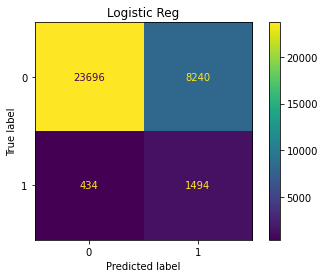

GradientBoostingClassifier> Train Accuracy: 0.8047215900787106, Test Accuracy: 0.7446846208362863
GradientBoostingClassifier> MCC is 0.27812124330293286
              precision    recall  f1-score   support

           0       0.98      0.74      0.85     31936
           1       0.16      0.80      0.26      1928

    accuracy                           0.74     33864
   macro avg       0.57      0.77      0.55     33864
weighted avg       0.94      0.74      0.81     33864



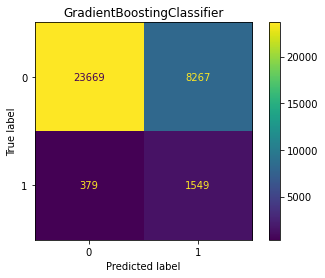

KNeighborsClassifier> Train Accuracy: 0.9028957972315594, Test Accuracy: 0.7812130876446964
KNeighborsClassifier> MCC is 0.22608787141883127
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     31936
           1       0.15      0.62      0.24      1928

    accuracy                           0.78     33864
   macro avg       0.56      0.71      0.56     33864
weighted avg       0.93      0.78      0.84     33864



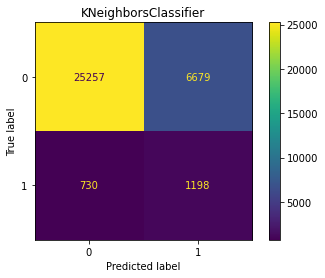

GaussianNB> Train Accuracy: 0.758215545858822, Test Accuracy: 0.6714800377982518
GaussianNB> MCC is 0.2261300140538005
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     31936
           1       0.13      0.81      0.22      1928

    accuracy                           0.67     33864
   macro avg       0.55      0.73      0.51     33864
weighted avg       0.93      0.67      0.76     33864



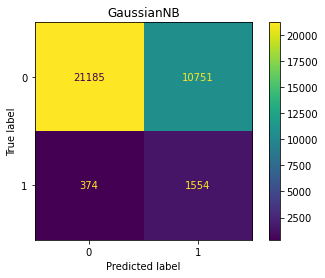

RandomForest> Train Accuracy: 0.9502265277574796, Test Accuracy: 0.8574592487597449
RandomForest> MCC is 0.22341503949450972
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     31936
           1       0.19      0.45      0.26      1928

    accuracy                           0.86     33864
   macro avg       0.58      0.67      0.59     33864
weighted avg       0.92      0.86      0.88     33864



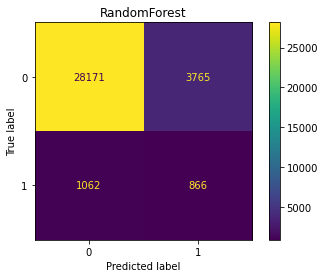

IndexError: ignored

In [ ]:
# check metrics to see how dropping the lowest 7 relevant variables affected metrics
for name, model in zip(names, models):
    info = {'clf':name, 'data':'Charlotte Policing'}
    train_eval(model, X_train_fs, T_train, X_test_fs, T_test, info)


#### SequentialFeatureSelector-based feature selection (Wrapper Method)

In [ ]:
import joblib
from sklearn.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
# Define Sequential Forward Selection (sfs)
# This is based on the cross-validation score of an unfitted estimator (LogReg)
sfs = SFS(LogisticRegression(),
           n_features_to_select=0.8,
           cv=3)

#Use SFS to select the top features (KNN and GB take too long, drop to Logreg)
sfs.fit(x_1, T_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


SequentialFeatureSelector(cv=3, estimator=LogisticRegression(),
                          n_features_to_select=0.8)

In [ ]:
# See selected variables (Driver_Race seems to be a relevant variable)
X_train.columns[sfs.get_support()]

Index(['Officer_Gender', 'Officer_Years_of_Service', 'Driver_Race',
       'Driver_Ethnicity', 'Driver_Gender', 'Driver_Age',
       'Reason_for_Stop_CheckPoint', 'Reason_for_Stop_Driving While Impaired',
       'Reason_for_Stop_Investigation', 'Reason_for_Stop_Other',
       'Reason_for_Stop_SeatBelt', 'Reason_for_Stop_Speeding',
       'Reason_for_Stop_Stop Light/Sign', 'Reason_for_Stop_Vehicle Regulatory',
       'CMPD_Division_Central Division', 'CMPD_Division_Eastway Division',
       'CMPD_Division_Freedom Division', 'CMPD_Division_Independence Division',
       'CMPD_Division_Metro Division', 'CMPD_Division_North Division',
       'CMPD_Division_North Tryon Division',
       'CMPD_Division_Providence Division', 'CMPD_Division_South Division',
       'CMPD_Division_Westover Division', 'Officer_Race_Asian',
       'Officer_Race_Black', 'Officer_Race_Native American'],
      dtype='object')

In [ ]:
# See unselected variables
X_train.columns[~sfs.get_support()]

Index(['Reason_for_Stop_Safe Movement', 'Reason_for_Stop_Vehicle Equipment',
       'CMPD_Division_Hickory Grove Division',
       'CMPD_Division_Steele Creek Division',
       'CMPD_Division_University City Division', 'Officer_Race_Other/Unknown',
       'Officer_Race_White'],
      dtype='object')

In [ ]:
# New DFs that will contain the undropped features (based on the sfs above)
X_train_res_sfs_drop = X_train.copy()[X_train.columns[sfs.get_support()]]
X_test_norm_sfs_drop = X_test.copy()[X_test.columns[sfs.get_support()]]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Reg> Train Accuracy: 0.7873979581184626, Test Accuracy: 0.7442416725726435
Logistic Reg> MCC is 0.2649564522363444
              precision    recall  f1-score   support

           0       0.98      0.74      0.85     31936
           1       0.15      0.77      0.26      1928

    accuracy                           0.74     33864
   macro avg       0.57      0.76      0.55     33864
weighted avg       0.93      0.74      0.81     33864



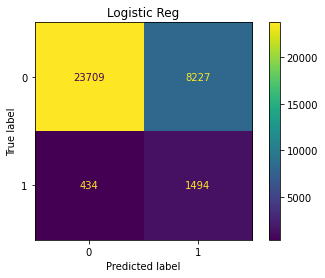

GradientBoostingClassifier> Train Accuracy: 0.8021066037538885, Test Accuracy: 0.7424108197495866
GradientBoostingClassifier> MCC is 0.2750928675355169
              precision    recall  f1-score   support

           0       0.98      0.74      0.84     31936
           1       0.16      0.80      0.26      1928

    accuracy                           0.74     33864
   macro avg       0.57      0.77      0.55     33864
weighted avg       0.94      0.74      0.81     33864



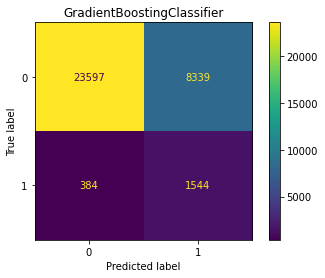

KNeighborsClassifier> Train Accuracy: 0.8891423262417271, Test Accuracy: 0.7660347271438696
KNeighborsClassifier> MCC is 0.2318333071360782
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     31936
           1       0.15      0.66      0.24      1928

    accuracy                           0.77     33864
   macro avg       0.56      0.72      0.55     33864
weighted avg       0.93      0.77      0.83     33864



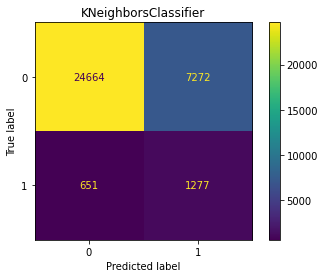

GaussianNB> Train Accuracy: 0.7573699814184605, Test Accuracy: 0.6720411055988661
GaussianNB> MCC is 0.22876059431342372
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     31936
           1       0.13      0.81      0.22      1928

    accuracy                           0.67     33864
   macro avg       0.56      0.74      0.51     33864
weighted avg       0.93      0.67      0.76     33864



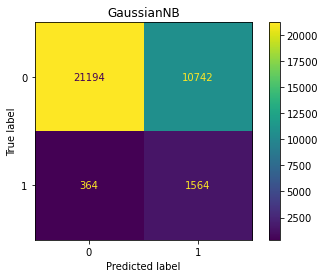

RandomForest> Train Accuracy: 0.934421780069733, Test Accuracy: 0.8367292700212615
RandomForest> MCC is 0.23064732735465818
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     31936
           1       0.18      0.51      0.26      1928

    accuracy                           0.84     33864
   macro avg       0.57      0.68      0.59     33864
weighted avg       0.92      0.84      0.87     33864



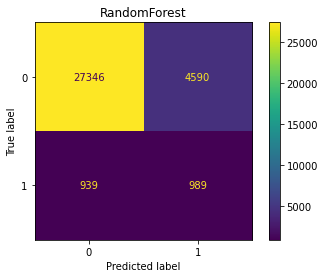

DemographicParityClassifier> Train Accuracy: 0.7868238094243898, Test Accuracy: 0.7430309473186865
DemographicParityClassifier> MCC is 0.26629861853485787
              precision    recall  f1-score   support

           0       0.98      0.74      0.84     31936
           1       0.15      0.78      0.26      1928

    accuracy                           0.74     33864
   macro avg       0.57      0.76      0.55     33864
weighted avg       0.94      0.74      0.81     33864



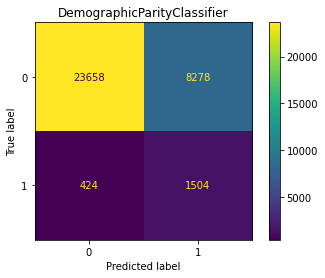

In [ ]:
# check metrics to see how dropping the irrelevant variables 
for name, model in zip(names, models):
    info = {'clf':name, 'data':'Charlotte Policing'}
    train_eval(model, X_train_res_sfs_drop, T_train, X_test_norm_sfs_drop, T_test, info)


#### Hyperparameter Tuning (Grid Search)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

pipe = Pipeline(steps=[('estimator', LogisticRegression())])

# Add a dict of estimator and estimator related parameters in this list
params_grid = [{
                'estimator':[LogisticRegression()],
                'estimator__penalty' : ['elasticnet', 'l2']
                },
                {
                'estimator': [GradientBoostingClassifier()],
                'estimator__learning_rate' : [0.15,0.1,0.05,0.01,0.005,0.001],
                'estimator__n_estimators' : [5,10,25,50,75]
                },
                {
                'estimator':[RandomForestClassifier()],
                'estimator__n_estimators':list(range(40,100,10)),
                'estimator__max_features': list(range(1,5,1)),
                'estimator__max_depth': list(range(3,6,1))
                },
                {
                'estimator': [GaussianNB()],
                 'estimator__var_smoothing':np.logspace(0,-9, num=100)
                }
              ]

grid = GridSearchCV(pipe, params_grid,cv=3,scoring='recall')
_ = grid.fit(X_train,T_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
grid.best_params_

{'estimator': GaussianNB(var_smoothing=0.0015199110829529332),
 'estimator__var_smoothing': 0.0015199110829529332}

In [ ]:
grid.best_score_

0.8979163478961644

In [ ]:
grid_y_train = grid.predict(X_train)
grid_y_test = grid.predict(X_test)

In [ ]:
from sklearn.metrics import recall_score
recall_score(T_test, grid_y_test)

0.8874481327800829

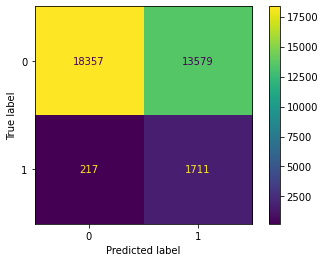

In [ ]:
    grid.cm = confusion_matrix(T_test, grid_y_test, labels=grid.classes_)
    grid.disp = ConfusionMatrixDisplay(confusion_matrix=grid.cm, display_labels=grid.classes_)

    grid.disp.plot()
    plt.show()

#### Hyperparameter Tuning (Randomized Search)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import random
from random import randint

In [ ]:
pipe_rand = Pipeline(steps=[('estimator', LogisticRegression())])

# Add a dict of estimator and estimator related parameters in this list
params_grid_rand = [{
                'estimator':[LogisticRegression()],
                'estimator__penalty' : ['elasticnet', 'l2']
                },
                {
                'estimator': [GradientBoostingClassifier()],
                'estimator__learning_rate' : [round(random.uniform(.001,0.15),2)],
                'estimator__n_estimators' : [randint(5,75)]
                },
                {
                'estimator':[RandomForestClassifier()],
                'estimator__n_estimators':[randint(40,100)],
                'estimator__max_features': [randint(1,5)],
                'estimator__max_depth': [randint(3,6)]
                },
                {
                'estimator': [GaussianNB()],
                 'estimator__var_smoothing':[random.uniform(min(np.logspace(0,-9, num=100)),max(np.logspace(0,-9, num=100)))]
                }
              ]

grid_rand = RandomizedSearchCV(pipe_rand, params_grid_rand,cv=3,scoring='recall',n_iter=250)
_ = grid_rand.fit(X_train,T_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 5 is smaller than n_iter=250. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the da

In [ ]:
grid_rand.best_params_

{'estimator': GaussianNB(var_smoothing=0.27091819453038984),
 'estimator__var_smoothing': 0.27091819453038984}

In [ ]:
grid_rand.best_score_

0.8704303018074359

In [ ]:
grid_rand_y_train = grid_rand.predict(X_train)
grid_rand_y_test = grid_rand.predict(X_test)

In [ ]:
recall_score(T_test, grid_rand_y_test)

0.8729253112033195

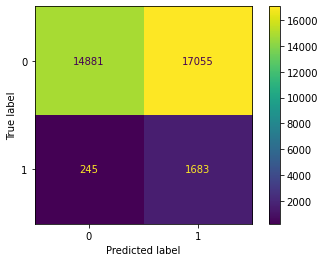

In [ ]:
    grid_rand.cm = confusion_matrix(T_test, grid_rand_y_test, labels=grid_rand.classes_)
    grid_rand.disp = ConfusionMatrixDisplay(confusion_matrix=grid_rand.cm, display_labels=grid_rand.classes_)

    grid_rand.disp.plot()
    plt.show()

## Code for looking at LogReg Coefficients

Logistic Regression> Train Accuracy: 0.786510637409441, Test Accuracy: 0.7440644932671864
Logistic Regression> MCC is 0.2650447448711235
              precision    recall  f1-score   support

           0       0.98      0.74      0.85     31936
           1       0.15      0.78      0.26      1928

    accuracy                           0.74     33864
   macro avg       0.57      0.76      0.55     33864
weighted avg       0.93      0.74      0.81     33864



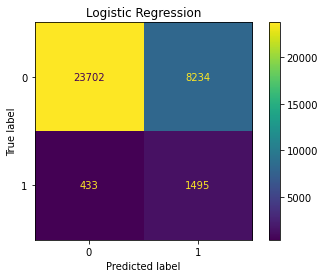

In [ ]:
logreg = LogisticRegression(max_iter = 1000)

info = {'clf':'Logistic Regression', 'data':'Charlotte Policing'}

train_eval(logreg, X_train, T_train, X_test, T_test, info)

In [ ]:
for index, val in enumerate(list(logreg.coef_[0])):
  print('Column: {} | Coefficient: {}'.format(X_train.columns[index], val))

Column: Officer_Gender | Coefficient: 0.3641838673160393
Column: Officer_Years_of_Service | Coefficient: -0.09558280445333853
Column: Driver_Race | Coefficient: 0.3620274569417135
Column: Driver_Ethnicity | Coefficient: 0.44917309237231756
Column: Driver_Gender | Coefficient: 1.3811342081295916
Column: Driver_Age | Coefficient: -0.04594782143633748
Column: Reason_for_Stop_CheckPoint | Coefficient: -2.8486312980929682
Column: Reason_for_Stop_Driving While Impaired | Coefficient: 3.595487139348231
Column: Reason_for_Stop_Investigation | Coefficient: 1.5795911563287555
Column: Reason_for_Stop_Other | Coefficient: -0.23492164450471997
Column: Reason_for_Stop_Safe Movement | Coefficient: -0.19028640219157292
Column: Reason_for_Stop_SeatBelt | Coefficient: -0.0652295760497277
Column: Reason_for_Stop_Speeding | Coefficient: -1.3466619145020389
Column: Reason_for_Stop_Stop Light/Sign | Coefficient: -0.7224648221063983
Column: Reason_for_Stop_Vehicle Equipment | Coefficient: -0.0282602343785588

## Attempt at Using P% Score

In [ ]:
GB = GradientBoostingClassifier()
GB.fit(X_train, T_train)

GradientBoostingClassifier()

In [ ]:
from sklego.metrics import p_percent_score
p_score = p_percent_score('Driver_Race')(GB, X_train, T_train)
p_score

0.3973456483842387

## Drawing Some P% Graphs with FairClassifier
Once we have finished hyper-tuning some models (excluding Fairness Classifiers) we can draw these graphs for the presentation. Essentially, these show the trade-off between different covariance thresholds and performance.

In [ ]:
from sklearn.metrics import accuracy_score, make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
import warnings
import numpy as np
from sklego.metrics import p_percent_score

In [ ]:
# Be careful, this takes 30 minutes.
fair_classifier = GridSearchCV(estimator=DemographicParityClassifier(sensitive_cols="Driver_Race",
                                                        covariance_threshold=0.5),
                               param_grid={"estimator__covariance_threshold":
                                           np.linspace(0.01, 1.00, 10)},
                               cv=3,
                               refit="accuracy_score",
                               return_train_score=True,
                               scoring={"p_percent_score": p_percent_score('Driver_Race'),
                                        "accuracy_score": make_scorer(accuracy_score),
                                        "recall_score":make_scorer(recall_score)})

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fair_classifier.fit(X_train, T_train);

    pltr = (pd.DataFrame(fair_classifier.cv_results_)
            .set_index("param_estimator__covariance_threshold"))

In [ ]:
logreg = LogisticRegression(max_iter = 1000)
# "col" not needed here since T_train is initialized with T_train, which only has 1 column. Thus, T_train is a Series.
logreg.fit(X_train, T_train)

LogisticRegression(max_iter=1000)

In [ ]:
p_score = p_percent_score('Driver_Race')(logreg, X_train, T_train)
acc_score = accuracy_score(logreg.predict(X_train), T_train)
recall_score = recall_score(logreg.predict(X_train), T_train)

In [ ]:
pltr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_p_percent_score,split1_test_p_percent_score,split2_test_p_percent_score,mean_test_p_percent_score,std_test_p_percent_score,...,split1_test_recall_score,split2_test_recall_score,mean_test_recall_score,std_test_recall_score,rank_test_recall_score,split0_train_recall_score,split1_train_recall_score,split2_train_recall_score,mean_train_recall_score,std_train_recall_score
param_estimator__covariance_threshold,,,,,,,,,,,,,,,,,,,,,
0.01,46.438545,0.372029,0.112914,0.002396,{'estimator__covariance_threshold': 0.01},0.605258,0.601396,0.614865,0.607173,0.005663,...,0.830891,0.829852,0.825699,0.006621,9,0.827553,0.824403,0.825956,0.825970,0.001286
0.12,48.205518,1.065251,0.115965,0.007962,{'estimator__covariance_threshold': 0.12},0.605258,0.601396,0.614865,0.607173,0.005663,...,0.830891,0.829852,0.825699,0.006621,9,0.827553,0.824403,0.825956,0.825970,0.001286
0.23,42.030330,0.704879,0.119183,0.002289,{'estimator__covariance_threshold': 0.23},0.581955,0.578475,0.579933,0.580121,0.001427,...,0.832300,0.833328,0.827599,0.007387,8,0.829729,0.825342,0.827756,0.827609,0.001794
0.34,42.516613,2.583723,0.110577,0.003160,{'estimator__covariance_threshold': 0.34},0.539511,0.544061,0.546452,0.543341,0.002879,...,0.833490,0.832514,0.828256,0.006723,1,0.831358,0.826094,0.828351,0.828601,0.002156
0.45,41.885204,0.630590,0.110414,0.008751,{'estimator__covariance_threshold': 0.45},0.539511,0.544061,0.546452,0.543341,0.002879,...,0.833490,0.832514,0.828256,0.006723,1,0.831358,0.826094,0.828351,0.828601,0.002156
0.56,44.461214,1.973536,0.132618,0.003927,{'estimator__covariance_threshold': 0.56},0.539511,0.544061,0.546452,0.543341,0.002879,...,0.833490,0.832514,0.828256,0.006723,1,0.831358,0.826094,0.828351,0.828601,0.002156
0.67,41.424342,0.671288,0.116912,0.006896,{'estimator__covariance_threshold': 0.67},0.539511,0.544061,0.546452,0.543341,0.002879,...,0.833490,0.832514,0.828256,0.006723,1,0.831358,0.826094,0.828351,0.828601,0.002156
0.78,44.718544,2.313847,0.118399,0.001916,{'estimator__covariance_threshold': 0.78},0.539511,0.544061,0.546452,0.543341,0.002879,...,0.833490,0.832514,0.828256,0.006723,1,0.831358,0.826094,0.828351,0.828601,0.002156
0.89,45.896526,1.977884,0.120283,0.008600,{'estimator__covariance_threshold': 0.89},0.539511,0.544061,0.546452,0.543341,0.002879,...,0.833490,0.832514,0.828256,0.006723,1,0.831358,0.826094,0.828351,0.828601,0.002156


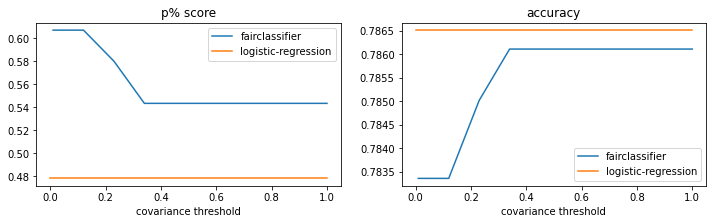

In [ ]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(np.array(pltr.index), pltr['mean_test_p_percent_score'], label='fairclassifier')
plt.plot(np.linspace(0, 1, 2), [p_score for _ in range(2)], label='logistic-regression')
plt.xlabel("covariance threshold")
plt.legend()
plt.title("p% score")
plt.subplot(122)
plt.plot(np.array(pltr.index), pltr['mean_test_accuracy_score'], label='fairclassifier')
plt.plot(np.linspace(0, 1, 2), [acc_score for _ in range(2)], label='logistic-regression')
plt.xlabel("covariance threshold")
plt.legend()
plt.title("accuracy");

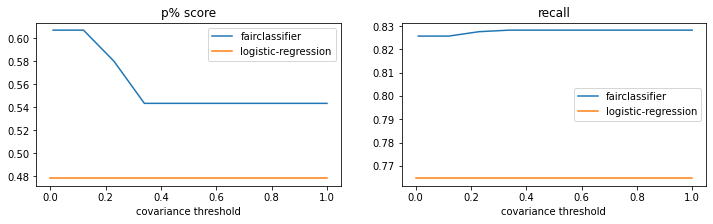

In [ ]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(np.array(pltr.index), pltr['mean_test_p_percent_score'], label='fairclassifier')
plt.plot(np.linspace(0, 1, 2), [p_score for _ in range(2)], label='logistic-regression')
plt.xlabel("covariance threshold")
plt.legend()
plt.title("p% score")
plt.subplot(122)
plt.plot(np.array(pltr.index), pltr['mean_test_recall_score'], label='fairclassifier')
plt.plot(np.linspace(0, 1, 2), [recall_score for _ in range(2)], label='logistic-regression')
plt.xlabel("covariance threshold")
plt.legend()
plt.title("recall");

## Fine Tuning Contrast Classifiers

## Final Comparison and Graph Output

## Export Models (To Streamlit!)